In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lion-pytorch
!pip install torcheval
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 14.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.3 MB/s eta 0:00:00


In [ ]:
import sys
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, RandomSampler
from pathlib import Path
from torchvision.datasets import ImageFolder
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
import random
import collections
import pickle
import torch.nn as nn
from torchvision.models import ResNet18_Weights
import tqdm
from torch import optim
from collections import Counter
import math
import shutil
import torch.nn.functional as F
from torcheval.metrics.functional import multiclass_f1_score
from torchmetrics.classification import MulticlassRecall,

import statistics




In [ ]:
! unzip /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_with_personal.zip

In [ ]:
def create_dataset(parent_directory_name):
    classes = os.listdir(parent_directory_name)

    # Preprocess the data:
    # Create the transformation for the pictures for them to be the same size and
    # Convert the picture to a tensor: a n dimensional array
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299))])
    print("class count numbers")
    for clas in classes:
        print(len(os.listdir(parent_directory_name + clas)))
    # Define the ImageFolder dataset
    # divide root folder in its subfolders and their image content
    dataset = ImageFolder(root=parent_directory_name, transform=transform)

    return dataset

def idx2class(dataset):
    # create a dictionary of the form idx:class_name
    idx2class = {v: k for k, v in dataset.class_to_idx.items()}
    return idx2class


In [ ]:
def save_to_file(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_from_file(file_name):
    # Load the classes with their img counts dictionary from the file
    with open(file_name, 'rb') as f:
        obj = pickle.load(f)
    return obj


def calculate_weights(dataset, class_distribution, dataset_name):
    if not os.path.exists("/content/drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_weights_train" + dataset_name + ".pickle"):
      print("/drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_weights_train" + dataset_name + ".pickle")
      print('file does not exist')
      # Calculate the weights of each class
      img_count_per_class = np.fromiter(class_distribution.values(), dtype=float)
      classes = class_distribution.keys()
      # the actual weights of classes
      raw_weights = len(dataset) / (len(classes) * img_count_per_class)

      # normalized weights : the bigger the number the lesser imgs are in that class
      weights = raw_weights / np.sum(raw_weights)

      weights_dict = {}
      for A, B in zip(classes, weights):
          weights_dict[A] = B
      print("weights_dict" + str(weights_dict))
      try:
          save_to_file(weights_dict,
                      f"drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_weights_" + dataset_name
                      + ".pickle")
          return weights_dict
      except Exception as e:  # work on python 3.x
        print('Failed to upload to ftp: ' + str(e))

    else:
      print('file exists')
      return load_from_file("/content/drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_weights_train" + dataset_name + ".pickle")



#get the number of pictures for each class
#return a dictionary of form class:nr_of_elements
def get_class_distribution(dataset, dataset_name):
    # Determine count of images per class in training_dataset
    # Collect the labels in a list or dictionary

    class_counts = dict(Counter(dataset.targets))
    print("class_counts" + str(class_counts))
    myKeys = list(class_counts.keys())
    myKeys.sort()
    sorted_class_counts = {i: class_counts[i] for i in myKeys}

    save_to_file(sorted_class_counts, "/content/drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_" + dataset_name + ".pickle")



def save_to_folders(train_dataset, val_dataset, test_dataset, classes, dir_name):
    if (not os.path.isdir(dir_name + "/test/Suillus")):
      output_folders = ['train', 'val', 'test']
      output_dirs = {
          output_folders[0]: dir_name + '/train',
          output_folders[1]:  dir_name + '/val',
          output_folders[2]: dir_name + '/test'
      }

      # Create the output directories if they don't exist
      for output_dir in output_dirs.values():
          Path(output_dir).mkdir(parents=True, exist_ok=True)
          for class_name in classes:
              Path(output_dir + "/" + class_name).mkdir(parents=True, exist_ok=True)
      subsets = [train_dataset, val_dataset, test_dataset]
      for i in range(len(subsets)):
          subset = subsets[i]
          for j in range(len(subset)):
              img_tensor = subset[j][0]
              label = subset[j][1]
              to_img_transform = transforms.ToPILImage()
              img = to_img_transform(img_tensor)
              img_name = "/" + str(j) + ".jpg"

              img.save(dir_name + "/" + output_folders[i] + "/" + classes[label] + img_name)



In [ ]:
# Define your subset as a PyTorch Dataset object
class MySubset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        # Return a single (tensor, label) tuple
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import statistics
def split_train_val_test(dataset):

    classes = os.listdir("Mushrooms_augmented_Mircea")

    idx2_class = idx2class(dataset)

    # Split dataset into train, validation, and test sets
    train_size = int(len(dataset) * 0.75)  # 75% train
    val_size = int(len(dataset) * 0.15)  # 15% val
    test_size = len(dataset) - train_size - val_size  # 10% test
    print("train:", train_size, "\nval:", val_size, "\ntest:", test_size)

    # Use the random_split function to split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

    # Save the distribution of the newly split dataset
    get_class_distribution(train_dataset, "train_personal")
    return train_dataset, val_dataset, test_dataset



In [ ]:
!unzip /content/drive/MyDrive/MyShroomClassifier/augmented_datasets/Mushrooms_output_train60_augment4_inception_personal.zip
!unzip /content/drive/MyDrive/MyShroomClassifier/augmented_datasets/Mushrooms_output_augment4_inception_personal.zip

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8272.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8273.jpg  
 extracting: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8274.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8275.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8276.jpg  
 extracting: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8277.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8278.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8279.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8280.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8281.jpg  
  inflating: Mushrooms_output_augment4_inception_personal/train/Hygrocybe/8282.j

In [ ]:


# Generate a dataset that has all classes with the same number of images that is -100 of the class[max(nr_of_images)]
def split_train_val_test_augment4(dataset, output_dir):
    # Use the random_split function to split the dataset
    if not os.path.isdir(output_dir + "/train/Agaricus"):

        parent_dir = "/content/Mushrooms_output_augment4_inception_personal"
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299))])

        train_dataset = datasets.ImageFolder(root=parent_dir+"/train", transform=transform)
        test_dataset = datasets.ImageFolder(root=parent_dir+"/test", transform=transform)
        val_dataset = datasets.ImageFolder(root=parent_dir+"/val", transform=transform)

        # train_dataset, val_dataset, test_dataset = split_train_val_test(dataset)

        classes = os.listdir("Mushrooms_augmented_Mircea")

        transform_list = [
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=30),

        ]
        util_files_dir = "drive/MyDrive/MyShroomClassifier/util_files"
        if (not os.path.isfile(util_files_dir + "/classes_with_their_img_count_augment4_inception_personal.pickle")):
            get_class_distribution(train_dataset, "train_personal")
        class_counts = load_from_file(util_files_dir + "/classes_with_their_img_count_augment4_inception_personal.pickle")
        print(class_counts)
        print("generated class counts for the training dataset raw")
        max_class_count = max(class_counts.values())

        current_data = [train_dataset.__getitem__(i) for i in range(len(train_dataset))]


        # Augment images with random transform based on the "class weight" --> count
        new_data = generate_data(current_data, class_counts, classes, transform_list, max_class_count)
        updated_data = current_data + new_data
        train_dataset = MySubset(updated_data)
        save_to_folders(train_dataset, val_dataset, test_dataset, classes, output_dir)
    else:
        print("Data folder already exists...You're ready to GO")


def generate_data(data, class_counts, classes, transform_list, max_class_count):
    # Create a list of augmented images and labels
    augmented_data = []
    for label_idx in classes:


        class_count = class_counts[label_idx]

        # Augment only classes that are below average of all class counts
        if class_count < max_class_count:

            # Determine the number of transformations to apply
            # optimal value must be found
            num_augmentations = max_class_count - class_count
            # Get the indices of the images in this class
            indices = []
            for i in range(len(data)):
                if data[i][1] == label_idx:
                    indices.append(i)
            print(len(indices))
            # print(num_augmentations)
            for augment in range(num_augmentations):
                # Select a random image from this class
                img_idx = random.randrange(0, len(indices))
                t = transforms.ToPILImage()
                img = t(data[indices[img_idx]][0])

                # Apply a random transformation
                transform_idx = random.randrange(0, len(transform_list))
                transform = transform_list[transform_idx]

                img = transform(img)
                to_tensor = transforms.ToTensor()
                img = to_tensor(img)
                # Add the transformed image and label to the list
                augmented_data.append((img, label_idx))

    return augmented_data


In [ ]:
from torchvision import transforms
import shutil

dataset=create_dataset("Mushrooms_augmented_Mircea/")
target_dir = "/content/drive/MyDrive/MyShroomClassifier/augmented_datasets/Mushrooms_output_train60_augment4_inception_personal.zip"
if not os.path.exists(target_dir):
  classes = os.listdir("Mushrooms_augmented_Mircea/")
  split_train_val_test_augment4(dataset, "Mushrooms_output_train60_augment4_inception_personal")


In [ ]:
!unzip /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_Mircea.zip

Archive:  /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_Mircea.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_Mircea.zip or
        /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_Mircea.zip.zip, and cannot find /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_Mircea.zip.ZIP, period.


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
import torch.nn.init as init
def init_weights(m):
   if isinstance(m, nn.Conv2d):
      init.normal_(m.weight, mean=0, std=0.01)
      if m.bias is not None:
          init.constant_(m.bias, 0)
   elif isinstance(m, nn.BatchNorm2d):
     init.constant_(m.weight, 1)
     init.constant_(m.bias, 0)
   elif isinstance(m, nn.Linear):
     init.normal_(m.weight, mean=0, std=0.01)
     if m.bias is not None:
      init.constant_(m.bias, 0)

In [ ]:
def prepare_model(device, train_dataset_weights=[]):
    model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
    model.aux_logits = False
    #maybe overfitting comes from not freezing the layers
    # model.apply(init_weights)
    for param in model.parameters():
        param.requires_grad = True

    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential( nn.Linear(out_features=9,in_features=num_ftrs), # 9 is the number of classes in your mushroom image dataset
                             nn.ReLU(), nn.Dropout(p=0.35)

    )

    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(train_dataset_weights.values()), dtype=torch.float32))
    criterion.to(device)

    # optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.001)
    # optimizer = optim.Adagrad(params=model.parameters(), lr = 0.001, weight_decay=0.001)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    # optimizer = Lion(model.parameters(), lr=0.00001, weight_decay=1e-2)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    return model, criterion, scheduler, optimizer


In [ ]:
def train_model(model, train_loader, val_loader, criterion,scheduler, optimizer, num_epochs, device):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    print("is on cuda:", next(model.parameters()).is_cuda)

    early_stopping = EarlyStopping(patience=6, verbose=True)
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_total = 0
        val_total = 0
        train_correct = 0
        val_correct = 0

        model.train()

        loop = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (inputs, labels) in loop:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          # Backward prop and optimization
          loss.backward()

          optimizer.step()


          train_loss += loss.item() * inputs.size(0)

          train_total += inputs.size(0)
          _, predicted = torch.max(outputs.data, 1)
          train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / train_total)
        train_accs.append(train_correct / train_total)

        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_total += inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

            val_losses.append(val_loss / val_total)
            val_accs.append(val_correct / val_total)

        loop.write(
            f'Epoch {epoch + 1} - Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_accs[-1]:.4f} - Val Loss: '
            f'{val_losses[-1]:.4f} - Val Acc: {val_accs[-1]:.4f} - learning rate: {optimizer.param_groups[0]["lr"]}')
        # Update the learning rate if necessary
        scheduler.step(val_losses[-1])
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


    return train_losses, val_losses, train_accs, val_accs


In [ ]:
from torchvision import transforms

transforms = transforms.Compose([transforms.Resize((299, 299)),

                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
dataset_dir ="/content/Mushrooms_output_augment4_inception_personal/"
util_files_dir = "/content/drive/MyDrive/MyShroomClassifier/util_files/"
train_dataset = datasets.ImageFolder(dataset_dir + "train", transform=transforms)
val_dataset = datasets.ImageFolder( dataset_dir + "val", transform=transforms)
test_dataset = datasets.ImageFolder(dataset_dir + "test", transform=transforms)


# Calculate the weights for each class(raw_weights) and the normalized version of it(train_dataset_weights
# Create dictionary with class label as keys and class_weight as values

# get_class_distribution(train_dataset, "train60_augment4_inception_personal")
train_dataset_distribution =load_from_file(util_files_dir +"classes_with_their_img_count_train_augment4_inception_personal.pickle")
train_dataset_normalized_weights = calculate_weights(train_dataset, train_dataset_distribution, "_augment4_inception_personal")
print(train_dataset_normalized_weights)
sample_weights = torch.Tensor([train_dataset_normalized_weights[label] for label in train_dataset.targets])

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)

print(len(train_dataset))
print(len(val_dataset))


batch_size = 128
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



file exists
{0: 0.10906985218937972, 1: 0.1115772051132735, 2: 0.1131783129893384, 3: 0.11011677049137202, 4: 0.10841393383428895, 5: 0.10897566406140961, 6: 0.11760840538966666, 7: 0.11227208094582947, 8: 0.10878777498544166}
10228
986


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, criterion, scheduler, optimizer = prepare_model(device, train_dataset_normalized_weights)
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion,scheduler, optimizer, 50, device)
print("MAX VALIDATION ACCURACY:",max(val_accs))


## **Class Distribution**
### Training

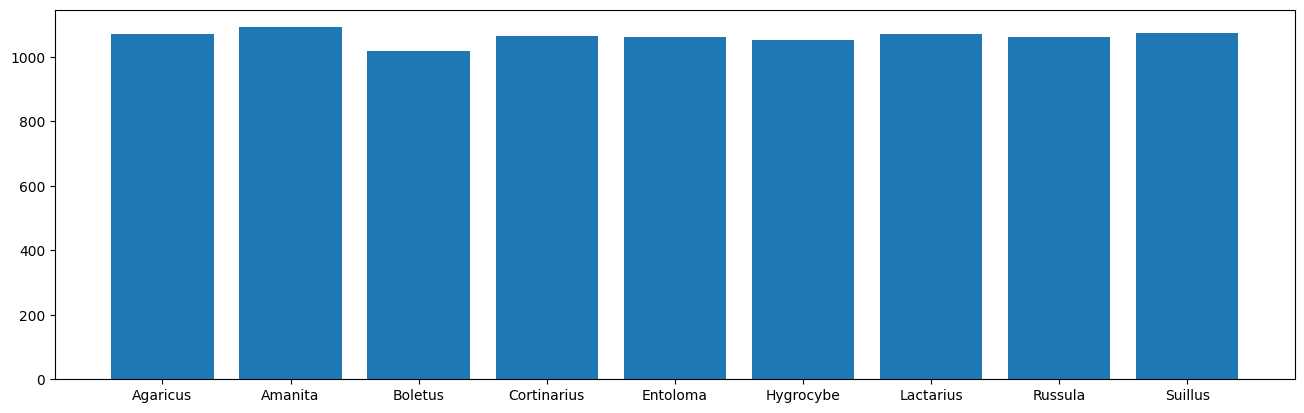

In [ ]:
import matplotlib.pyplot as plt
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}

    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    for _,j in dataloader_obj:

      y_indexes = j.data

      for y_index in y_indexes:
        y_lbl = idx2class[y_index.item()]
        count_dict[str(y_lbl)] += 1

    return count_dict

class_distr_val = get_class_distribution_loaders(val_loader, val_dataset)
class_distr_train = get_class_distribution_loaders(train_loader, train_dataset)


names_train = list(class_distr_train.keys())

values_train = class_distr_train.values()
values_val = class_distr_val.values()

#train_dataset distribution after augmentation
plt.figure().set_figwidth(16)
plt.bar(range(len(class_distr_val)), values_train, tick_label=names_train)
plt.show()



### Validation

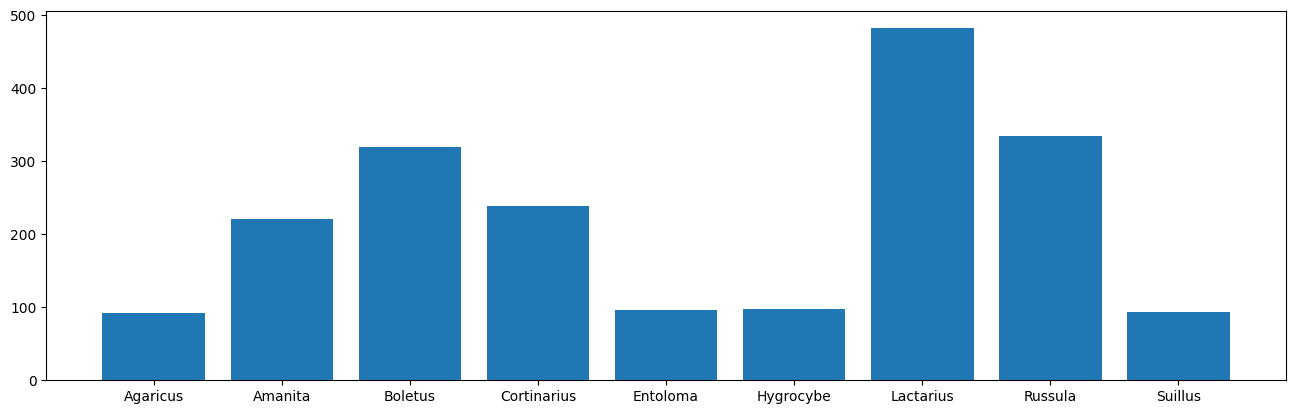

In [ ]:
#validation data_set distribution
plt.figure().set_figwidth(16)
plt.bar(range(len(class_distr_val)), values_val, tick_label=names_train)
plt.show()


In [ ]:
print(len(train_dataset))

10228


## **Visualization of training process**

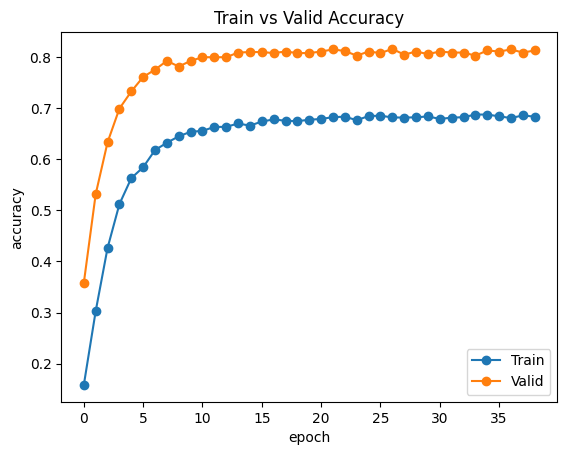

Text(0.5, 1.0, 'Train vs Valid Loss')

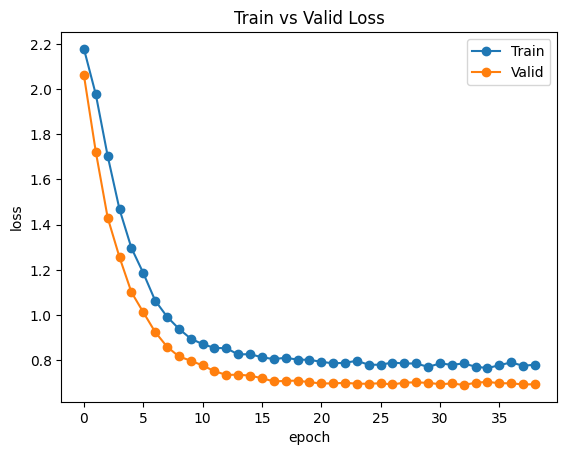

In [ ]:

plt.plot(train_accs,'-o')
plt.plot(val_accs,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')



# **TESTING**

In [ ]:
def test_model(model):
  model.to("cuda")
  test_loss = 0
  correct = 0
  total = 0
  print(len(test_loader))
  expected_classes = []
  predicted_classes = []
  model.eval()
  # Disable gradient computation for efficiency
  with torch.no_grad():
      # Iterate over the test dataset
      for data, target in test_loader:
          # Move the data to the specified device
          data, target = data.to(device), target.to(device)
          expected_classes.extend(target.int().tolist())
          # Forward pass
          output = model(data)

          # Compute the loss
          test_loss += F.cross_entropy(output, target, reduction='sum').item()

          # Compute the predicted classes
          _, predicted = torch.max(output.data, 1)

          predicted_classes.extend(predicted.int().tolist())
          # Update the accuracy
          total += target.size(0)
          correct += (predicted == target).sum().item()

  # Compute the average test loss and accuracy
  test_loss /= len(test_loader.dataset)
  test_acc = 100. * correct / total

  # Print the test results
  # print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_acc))

  # Return the test loss and accuracy
  return test_loss, test_acc, expected_classes,predicted_classes

test_losses, test_accs,expected_classes, predicted_classes = test_model(model)




8


## **TEST with F1 Score:**

In [ ]:
predicted_tensor = torch.Tensor(predicted_classes)
expected_tensor = torch.Tensor(expected_classes)
#F1 Score
print(f"F1 Score: {multiclass_f1_score(predicted_tensor, expected_tensor, num_classes=9)}")


F1 Score: 0.7922999262809753


## **TEST with Recall Metric**

In [ ]:
metric = MulticlassRecall(num_classes=9, average='weighted')
print(f"Recall metric: {metric(predicted_tensor, expected_tensor)}")

Recall metric: 0.7922998666763306


In [ ]:
model.to("cpu")

In [ ]:

# Switch the model to eval model
model.eval()

# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 3, 224, 224)
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example)

# Save the TorchScript model
traced_script_module.save('drive/MyDrive/MyShroomClassifier/Models/traced_model_resnet34_a4_6194_with_adagrad.pt')